In [111]:
import pandas as pd
import numpy as np
import ee
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

#1. DATA LOADING AND EXPLORATION

In [112]:
df = pd.read_excel("indeks2024.xlsx")

In [113]:
df.head(10)

,Provinsi,Poverty_Index,Latitude,Longitude,Unnamed: 4
0,ACEH,12.64,4.695135,96.749399,NaN
1,SUMATERA UTARA,7.19,2.115355,99.545097,NaN
2,SUMATERA BARAT,5.42,-0.739940,100.800005,NaN
3,RIAU,6.36,0.293347,101.706829,NaN
4,JAMBI,7.26,-1.485183,102.438058,NaN
5,SUMATERA SELATAN,10.51,-3.319437,103.914399,NaN
6,BENGKULU,12.52,-3.577847,102.346388,NaN
7,LAMPUNG,10.62,-4.558585,105.406808,NaN
8,KEP. BANGKA BELITUNG,5.08,-2.741051,106.440587,NaN
9,KEP. RIAU,4.78,3.945651,108.142867,NaN


In [114]:
df.shape

(37, 5)

In [115]:
df.drop(columns=["Provinsi", "Unnamed: 4"], inplace=True)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poverty_Index  37 non-null     float64
 1   Latitude       37 non-null     float64
 2   Longitude      37 non-null     float64
dtypes: float64(3)
memory usage: 1020.0 bytes


In [117]:
df.describe()

,Poverty_Index,Latitude,Longitude
count,37.000000,37.000000,37.000000
mean,10.494865,-2.905654,115.680651
std,6.366674,3.736235,11.767079
min,3.800000,-8.657382,96.749399
25%,5.700000,-6.211544,106.440587
50%,9.560000,-3.238462,115.188916
75%,12.520000,-0.278781,122.174605
max,29.660000,4.695135,138.764800


In [118]:
df.isnull().sum()

,0
Poverty_Index,0
Latitude,0
Longitude,0


#2. GEOSPATIAL DATA COLLECTION

In [119]:
df.head()

,Poverty_Index,Latitude,Longitude
0,12.64,4.695135,96.749399
1,7.19,2.115355,99.545097
2,5.42,-0.739940,100.800005
3,6.36,0.293347,101.706829
4,7.26,-1.485183,102.438058


In [120]:
# Initialize Google Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='ee-steviaanlenaa')

# Function to fetch geospatial data
def fetch_geospatial_data(lat, lon):
    point = ee.Geometry.Point(lon, lat).buffer(10000)  # 10km buffer
    end_date = ee.Date("2024-01-01")
    start_date = end_date.advance(-60, "day")  # 60-day period

    try:
        # Nighttime Lights (VIIRS)
        viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")\
            .filterDate(start_date, end_date)\
            .select("avg_rad")\
            .mean()\
            .reduceRegion(reducer=ee.Reducer.mean(), geometry=point, scale=500, bestEffort=True)
        night_lights = viirs.getInfo().get("avg_rad", np.nan)

        # Daylight Duration (ERA5)
        solar = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")\
            .filterDate(start_date, end_date)\
            .select("surface_solar_radiation_downwards")\
            .mean()\
            .reduceRegion(reducer=ee.Reducer.mean(), geometry=point, scale=500, bestEffort=True)
        daylight_duration = solar.getInfo().get("surface_solar_radiation_downwards", np.nan)

        print(f"Lat: {lat}, Lon: {lon} -> Night Lights: {night_lights}, Daylight Duration: {daylight_duration}")
        return night_lights, daylight_duration
    except Exception as e:
        print("Error fetching geospatial data:", str(e))
        return np.nan, np.nan

df["Night_Lights"], df["Daylight_Duration"] = zip(*df.apply(lambda row: fetch_geospatial_data(row["Latitude"], row["Longitude"]), axis=1))

df = df.dropna()

if df.empty:
    raise ValueError("No data left after preprocessing. Check geospatial data fetching and input file.")
df.head()

Lat: 4.695135, Lon: 96.7493993 -> Night Lights: 0.37557116888730824, Daylight Duration: 10509469.674845738
Lat: 2.1153547, Lon: 99.5450974 -> Night Lights: 0.12988677413354932, Daylight Duration: 10585868.050452534
Lat: -0.7399397, Lon: 100.8000051 -> Night Lights: 0.03242087295689579, Daylight Duration: 11882843.98647012
Lat: 0.2933469, Lon: 101.7068294 -> Night Lights: 0.42811377868869477, Daylight Duration: 11641271.160402158
Lat: -1.4851831, Lon: 102.4380581 -> Night Lights: 0.6239315647825784, Daylight Duration: 13368051.431123504
Lat: -3.3194374, Lon: 103.914399 -> Night Lights: 1.0225577550791833, Daylight Duration: 14636658.083862498
Lat: -3.5778471, Lon: 102.3463875 -> Night Lights: 0.30415367416605554, Daylight Duration: 14439241.504615933
Lat: -4.5585849, Lon: 105.4068079 -> Night Lights: 0.6221974780903287, Daylight Duration: 14949560.326478936
Lat: -2.7410513, Lon: 106.4405872 -> Night Lights: 0.2775935957257204, Daylight Duration: 14980872.867282959
Lat: 3.9456514, Lon: 1

,Poverty_Index,Latitude,Longitude,Night_Lights,Daylight_Duration
0,12.64,4.695135,96.749399,0.375571,1.050947e+07
1,7.19,2.115355,99.545097,0.129887,1.058587e+07
2,5.42,-0.739940,100.800005,0.032421,1.188284e+07
3,6.36,0.293347,101.706829,0.428114,1.164127e+07
4,7.26,-1.485183,102.438058,0.623932,1.336805e+07


In [121]:
original_count = len(df)
df = df.dropna()

In [122]:
print(f"Dropped {original_count - len(df)} rows with missing values")

Dropped 0 rows with missing values


In [123]:
if df.empty:
    raise ValueError("No data left after preprocessing. Check geospatial data fetching and input file.")

In [124]:
df.head()

,Poverty_Index,Latitude,Longitude,Night_Lights,Daylight_Duration
0,12.64,4.695135,96.749399,0.375571,1.050947e+07
1,7.19,2.115355,99.545097,0.129887,1.058587e+07
2,5.42,-0.739940,100.800005,0.032421,1.188284e+07
3,6.36,0.293347,101.706829,0.428114,1.164127e+07
4,7.26,-1.485183,102.438058,0.623932,1.336805e+07


#3. DATA PREPROCESSING AND VISUALIZATION

In [125]:
os.makedirs("plots", exist_ok=True)

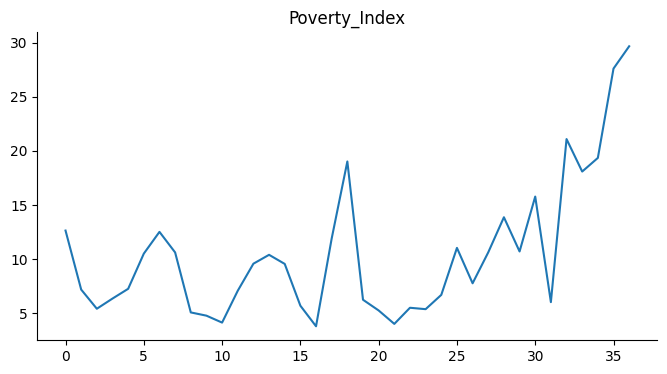

In [126]:
df['Poverty_Index'].plot(kind='line', figsize=(8, 4), title='Poverty_Index')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.savefig("plots/poverty_index_line.png")
plt.show()

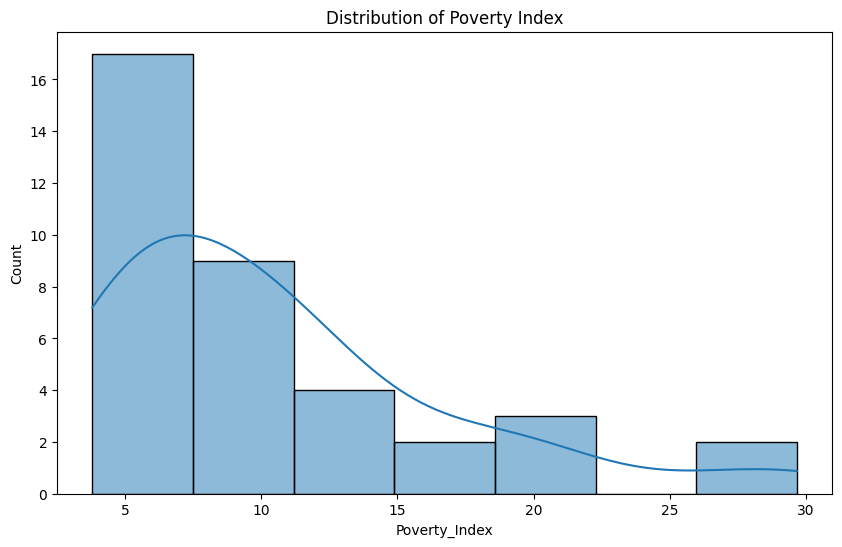

In [127]:
plt.figure(figsize=(10, 6))
sns.histplot(df["Poverty_Index"], kde=True)
plt.title("Distribution of Poverty Index")
plt.savefig("plots/poverty_index_distribution.png")
plt.show()

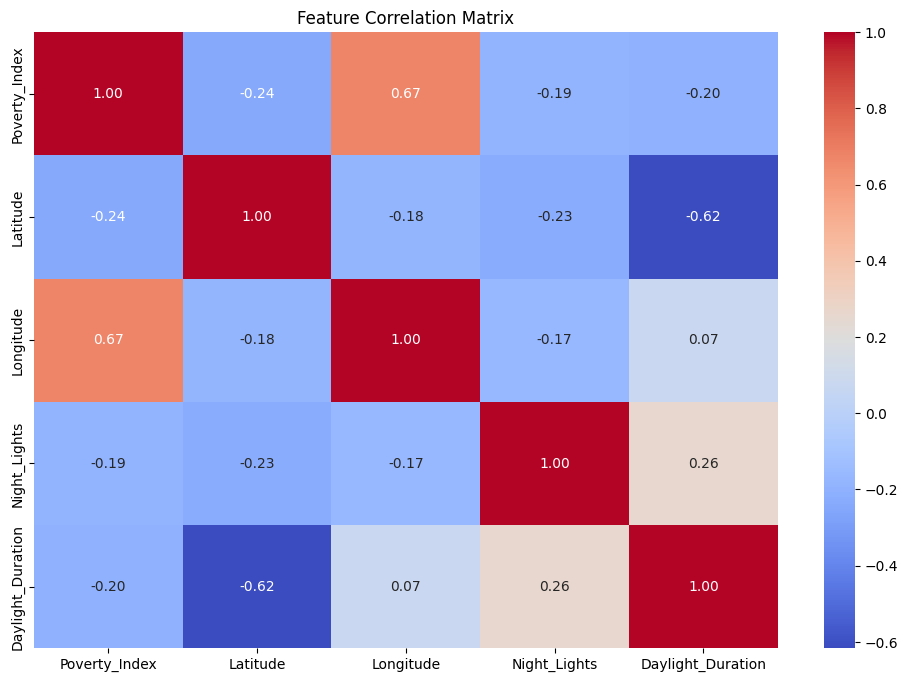

In [128]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.savefig("plots/correlation_matrix.png")
plt.show()

Text(0.5, 1.0, 'Night Lights vs Poverty Index')

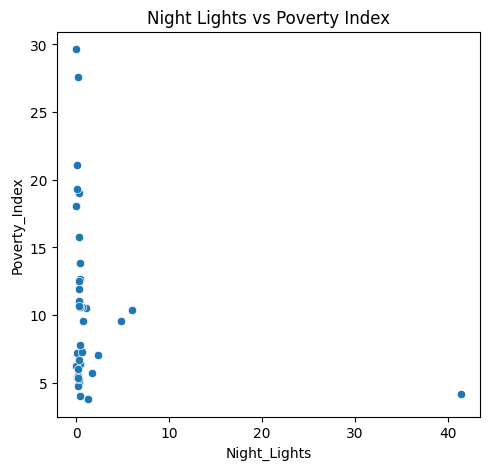

In [129]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x="Night_Lights", y="Poverty_Index", data=df)
plt.title("Night Lights vs Poverty Index")

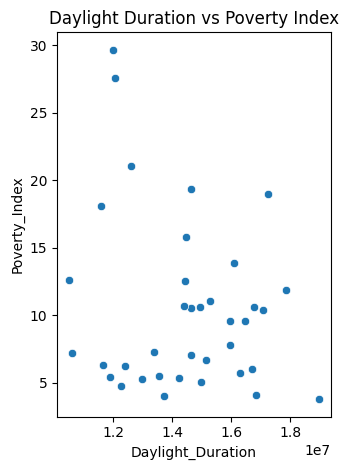

In [130]:
plt.subplot(1, 2, 2)
sns.scatterplot(x="Daylight_Duration", y="Poverty_Index", data=df)
plt.title("Daylight Duration vs Poverty Index")
plt.tight_layout()
plt.savefig("plots/feature_scatter_plots.png")
plt.show()

#4. DATA PREPARATION FOR MODELING

In [131]:
feature_cols = ["Night_Lights", "Daylight_Duration"]
X = df[feature_cols]
y = df["Poverty_Index"]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#5. RANDOM FOREST MODEL

In [134]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [135]:
rf = RandomForestRegressor(random_state=42)

In [136]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

In [137]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error', verbose=1)

In [138]:
best_rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}


In [139]:
rf_y_pred = best_rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

In [140]:
print(f"Random Forest Results:")
print(f"  - Mean Absolute Error: {rf_mae:.4f}")
print(f"  - Root Mean Squared Error: {np.sqrt(rf_mse):.4f}")
print(f"  - R² Score: {rf_r2:.4f}")

Random Forest Results:
  - Mean Absolute Error: 4.3835
  - Root Mean Squared Error: 7.7241
  - R² Score: -0.6581


In [141]:
feature_importance = pd.DataFrame(
    best_rf.feature_importances_,
    index=X_train.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

print("\nFeature importance:")
print(feature_importance)


Feature importance:
                   importance
Night_Lights         0.694876
Daylight_Duration    0.305124


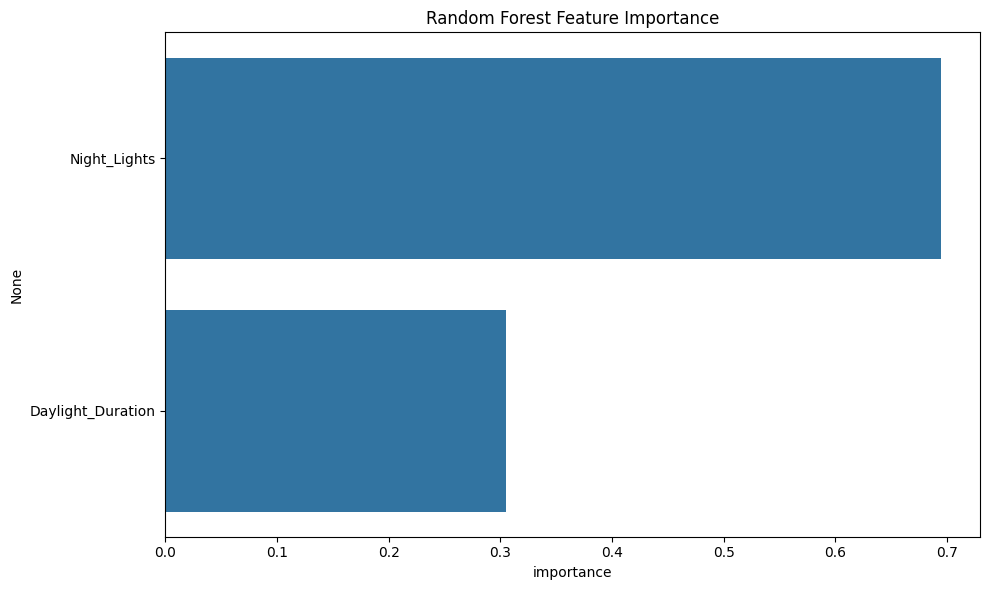

In [142]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.importance, y=feature_importance.index)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig("plots/rf_feature_importance.png")
plt.show()

#6. CNN MODEL

In [143]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [144]:
os.makedirs("models", exist_ok=True)

In [145]:
cnn_model = Sequential([
    # First convolution layer
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_scaled.shape[1], 1), padding='same'),
    MaxPooling1D(pool_size=2), # pool_size reduced to 1

    # Second convolution layer
    #Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'),  # This layer is commented out
    #MaxPooling1D(pool_size=2), # This layer is commented out or pool_size reduced to 1

    # Flatten the output
    Flatten(),

    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),

    # Output layer
    Dense(1)
])

In [146]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

In [147]:
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 2, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,465 (25.25 KB)

 Trainable params: 6,465 (25.25 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'models/cnn_model_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [149]:
history = cnn_model.fit(
    X_train_reshaped,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 140.0420 - mae: 9.8324
Epoch 1: val_loss improved from inf to 136.34676, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 140.0420 - mae: 9.8324 - val_loss: 136.3468 - val_mae: 10.6510
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 139.5384 - mae: 9.8010
Epoch 2: val_loss improved from 136.34676 to 135.81728, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 139.5384 - mae: 9.8010 - val_loss: 135.8173 - val_mae: 10.6292
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 139.0744 - mae: 9.7796
Epoch 3: val_loss improved from 135.81728 to 135.23747, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 139.0744 - mae: 9.7796 - val_loss: 135.2375 - val_mae: 10.6057
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 138.8526 - mae: 9.7683
Epoch 4: val_loss improved from 135.23747 to 134.64006, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 138.8526 - mae: 9.7683 - val_loss: 134.6401 - val_mae: 10.5819
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 138.4283 - mae: 9.7355
Epoch 5: val_loss improved from 134.64006 to 134.05374, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 138.4283 - mae: 9.7355 - val_loss: 134.0537 - val_mae: 10.5586
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 137.9558 - mae: 9.7134
Epoch 6: val_loss improved from 134.05374 to 133.49574, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 137.9558 - mae: 9.7134 - val_loss: 133.4957 - val_mae: 10.5362
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 137.7002 - mae: 9.6919
Epoch 7: val_loss improved from 133.49574 to 132.92534, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 137.7002 - mae: 9.6919 - val_loss: 132.9253 - val_mae: 10.5128
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 137.0490 - mae: 9.6520
Epoch 8: val_loss improved from 132.92534 to 132.33684, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 137.0490 - mae: 9.6520 - val_loss: 132.3368 - val_mae: 10.4887
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 136.5962 - mae: 9.6359
Epoch 9: val_loss improved from 132.33684 to 131.73645, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 136.5962 - mae: 9.6359 - val_loss: 131.7365 - val_mae: 10.4639
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 136.3186 - mae: 9.6229
Epoch 10: val_loss improved from 131.73645 to 131.09981, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 136.3186 - mae: 9.6229 - val_loss: 131.0998 - val_mae: 10.4374
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 135.8700 - mae: 9.5859
Epoch 11: val_loss improved from 131.09981 to 130.43037, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 135.8700 - mae: 9.5859 - val_loss: 130.4304 - val_mae: 10.4095
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 134.8677 - mae: 9.5284
Epoch 12: val_loss improved from 130.43037 to 129.73450, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 134.8677 - mae: 9.5284 - val_loss: 129.7345 - val_mae: 10.3801
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 134.4234 - mae: 9.5141
Epoch 13: val_loss improved from 129.73450 to 129.00142, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 134.4234 - mae: 9.5141 - val_loss: 129.0014 - val_mae: 10.3490
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 133.7975 - mae: 9.4735
Epoch 14: val_loss improved from 129.00142 to 128.23604, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 133.7975 - mae: 9.4735 - val_loss: 128.2360 - val_mae: 10.3162
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 133.1847 - mae: 9.4371
Epoch 15: val_loss improved from 128.23604 to 127.43569, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 133.1847 - mae: 9.4371 - val_loss: 127.4357 - val_mae: 10.2816
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 132.9566 - mae: 9.4099
Epoch 16: val_loss improved from 127.43569 to 126.59873, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 132.9566 - mae: 9.4099 - val_loss: 126.5987 - val_mae: 10.2451
Epoch 17/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 131.9443 - mae: 9.3781
Epoch 17: val_loss improved from 126.59873 to 125.72610, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 131.9443 - mae: 9.3781 - val_loss: 125.7261 - val_mae: 10.2068
Epoch 18/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 131.1166 - mae: 9.2971
Epoch 18: val_loss improved from 125.72610 to 124.81313, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 131.1166 - mae: 9.2971 - val_loss: 124.8131 - val_mae: 10.1664
Epoch 19/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 129.7783 - mae: 9.2228
Epoch 19: val_loss improved from 124.81313 to 123.83227, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 129.7783 - mae: 9.2228 - val_loss: 123.8323 - val_mae: 10.1228
Epoch 20/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 129.5038 - mae: 9.2208
Epoch 20: val_loss improved from 123.83227 to 122.77883, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 129.5038 - mae: 9.2208 - val_loss: 122.7788 - val_mae: 10.0757
Epoch 21/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 128.8387 - mae: 9.1474
Epoch 21: val_loss improved from 122.77883 to 121.65039, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 128.8387 - mae: 9.1474 - val_loss: 121.6504 - val_mae: 10.0253
Epoch 22/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 127.9830 - mae: 9.1066
Epoch 22: val_loss improved from 121.65039 to 120.45747, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 127.9830 - mae: 9.1066 - val_loss: 120.4575 - val_mae: 9.9720
Epoch 23/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 125.9513 - mae: 9.0174
Epoch 23: val_loss improved from 120.45747 to 119.20399, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 125.9513 - mae: 9.0174 - val_loss: 119.2040 - val_mae: 9.9156
Epoch 24/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 124.6334 - mae: 8.9569
Epoch 24: val_loss improved from 119.20399 to 117.89509, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 124.6334 - mae: 8.9569 - val_loss: 117.8951 - val_mae: 9.8561
Epoch 25/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 124.4714 - mae: 8.8840
Epoch 25: val_loss improved from 117.89509 to 116.53409, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 124.4714 - mae: 8.8840 - val_loss: 116.5341 - val_mae: 9.7938
Epoch 26/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 123.1400 - mae: 8.8320
Epoch 26: val_loss improved from 116.53409 to 115.10783, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 123.1400 - mae: 8.8320 - val_loss: 115.1078 - val_mae: 9.7276
Epoch 27/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 121.9577 - mae: 8.7671
Epoch 27: val_loss improved from 115.10783 to 113.61213, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 121.9577 - mae: 8.7671 - val_loss: 113.6121 - val_mae: 9.6575
Epoch 28/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 120.4524 - mae: 8.6741
Epoch 28: val_loss improved from 113.61213 to 112.05170, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 120.4524 - mae: 8.6741 - val_loss: 112.0517 - val_mae: 9.5837
Epoch 29/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 118.9270 - mae: 8.5752
Epoch 29: val_loss improved from 112.05170 to 110.42223, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 118.9270 - mae: 8.5752 - val_loss: 110.4222 - val_mae: 9.5059
Epoch 30/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 118.8199 - mae: 8.4978
Epoch 30: val_loss improved from 110.42223 to 108.71722, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 118.8199 - mae: 8.4978 - val_loss: 108.7172 - val_mae: 9.4238
Epoch 31/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 116.4444 - mae: 8.4135
Epoch 31: val_loss improved from 108.71722 to 106.93680, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 116.4444 - mae: 8.4135 - val_loss: 106.9368 - val_mae: 9.3372
Epoch 32/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 116.0436 - mae: 8.3803
Epoch 32: val_loss improved from 106.93680 to 105.07359, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 116.0436 - mae: 8.3803 - val_loss: 105.0736 - val_mae: 9.2452
Epoch 33/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 113.5657 - mae: 8.2470
Epoch 33: val_loss improved from 105.07359 to 103.11908, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 113.5657 - mae: 8.2470 - val_loss: 103.1191 - val_mae: 9.1472
Epoch 34/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 110.8389 - mae: 8.2054
Epoch 34: val_loss improved from 103.11908 to 101.07492, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 110.8389 - mae: 8.2054 - val_loss: 101.0749 - val_mae: 9.0432
Epoch 35/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 108.6894 - mae: 8.1327
Epoch 35: val_loss improved from 101.07492 to 98.92747, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 108.6894 - mae: 8.1327 - val_loss: 98.9275 - val_mae: 8.9323
Epoch 36/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 107.0995 - mae: 7.9681
Epoch 36: val_loss improved from 98.92747 to 96.65879, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 107.0995 - mae: 7.9681 - val_loss: 96.6588 - val_mae: 8.8137
Epoch 37/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 106.0010 - mae: 7.8761
Epoch 37: val_loss improved from 96.65879 to 94.26974, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 106.0010 - mae: 7.8761 - val_loss: 94.2697 - val_mae: 8.6873
Epoch 38/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 103.2554 - mae: 7.8056
Epoch 38: val_loss improved from 94.26974 to 91.76975, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 103.2554 - mae: 7.8056 - val_loss: 91.7698 - val_mae: 8.5531
Epoch 39/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 102.1459 - mae: 7.7266
Epoch 39: val_loss improved from 91.76975 to 89.15159, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 102.1459 - mae: 7.7266 - val_loss: 89.1516 - val_mae: 8.4106
Epoch 40/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 98.3376 - mae: 7.4355
Epoch 40: val_loss improved from 89.15159 to 86.43097, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 98.3376 - mae: 7.4355 - val_loss: 86.4310 - val_mae: 8.2595
Epoch 41/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 95.3857 - mae: 7.4600
Epoch 41: val_loss improved from 86.43097 to 83.64053, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 95.3857 - mae: 7.4600 - val_loss: 83.6405 - val_mae: 8.1011
Epoch 42/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 95.2359 - mae: 7.2666
Epoch 42: val_loss improved from 83.64053 to 80.80674, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 95.2359 - mae: 7.2666 - val_loss: 80.8067 - val_mae: 7.9362
Epoch 43/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 91.3467 - mae: 7.0087
Epoch 43: val_loss improved from 80.80674 to 77.89563, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 91.3467 - mae: 7.0087 - val_loss: 77.8956 - val_mae: 7.7626
Epoch 44/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 90.2951 - mae: 6.9878
Epoch 44: val_loss improved from 77.89563 to 74.95737, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 90.2951 - mae: 6.9878 - val_loss: 74.9574 - val_mae: 7.5823
Epoch 45/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 85.0585 - mae: 6.5759
Epoch 45: val_loss improved from 74.95737 to 71.91068, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 85.0585 - mae: 6.5759 - val_loss: 71.9107 - val_mae: 7.3911
Epoch 46/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 88.0250 - mae: 6.7771
Epoch 46: val_loss improved from 71.91068 to 68.80344, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 88.0250 - mae: 6.7771 - val_loss: 68.8034 - val_mae: 7.1909
Epoch 47/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 80.6532 - mae: 6.3416
Epoch 47: val_loss improved from 68.80344 to 65.62162, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 80.6532 - mae: 6.3416 - val_loss: 65.6216 - val_mae: 6.9802
Epoch 48/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 80.3147 - mae: 6.3757
Epoch 48: val_loss improved from 65.62162 to 62.47035, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 80.3147 - mae: 6.3757 - val_loss: 62.4703 - val_mae: 6.7635
Epoch 49/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 75.5446 - mae: 6.0693
Epoch 49: val_loss improved from 62.47035 to 59.31456, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 75.5446 - mae: 6.0693 - val_loss: 59.3146 - val_mae: 6.5382
Epoch 50/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 75.5639 - mae: 5.9835
Epoch 50: val_loss improved from 59.31456 to 56.19943, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 75.5639 - mae: 5.9835 - val_loss: 56.1994 - val_mae: 6.3063
Epoch 51/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 74.7746 - mae: 5.9572
Epoch 51: val_loss improved from 56.19943 to 53.20597, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 74.7746 - mae: 5.9572 - val_loss: 53.2060 - val_mae: 6.0720
Epoch 52/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 70.0142 - mae: 5.7032
Epoch 52: val_loss improved from 53.20597 to 50.28534, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 70.0142 - mae: 5.7032 - val_loss: 50.2853 - val_mae: 5.8326
Epoch 53/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 71.4946 - mae: 5.8193
Epoch 53: val_loss improved from 50.28534 to 47.54222, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 71.4946 - mae: 5.8193 - val_loss: 47.5422 - val_mae: 5.5945
Epoch 54/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 62.2065 - mae: 5.4828
Epoch 54: val_loss improved from 47.54222 to 44.90847, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 62.2065 - mae: 5.4828 - val_loss: 44.9085 - val_mae: 5.3559
Epoch 55/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 61.3452 - mae: 5.2795
Epoch 55: val_loss improved from 44.90847 to 42.41991, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 61.3452 - mae: 5.2795 - val_loss: 42.4199 - val_mae: 5.2150
Epoch 56/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 58.7375 - mae: 5.4819
Epoch 56: val_loss improved from 42.41991 to 40.10720, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 58.7375 - mae: 5.4819 - val_loss: 40.1072 - val_mae: 5.0775
Epoch 57/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 56.1035 - mae: 5.2983
Epoch 57: val_loss improved from 40.10720 to 37.95307, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 56.1035 - mae: 5.2983 - val_loss: 37.9531 - val_mae: 4.9428
Epoch 58/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 58.2069 - mae: 5.2878
Epoch 58: val_loss improved from 37.95307 to 36.00351, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 58.2069 - mae: 5.2878 - val_loss: 36.0035 - val_mae: 4.8137
Epoch 59/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 55.7727 - mae: 5.3518
Epoch 59: val_loss improved from 36.00351 to 34.29304, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 55.7727 - mae: 5.3518 - val_loss: 34.2930 - val_mae: 4.7039
Epoch 60/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 55.7175 - mae: 5.2121
Epoch 60: val_loss improved from 34.29304 to 32.78753, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 55.7175 - mae: 5.2121 - val_loss: 32.7875 - val_mae: 4.6812
Epoch 61/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 54.2655 - mae: 5.3049
Epoch 61: val_loss improved from 32.78753 to 31.50448, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 54.2655 - mae: 5.3049 - val_loss: 31.5045 - val_mae: 4.6660
Epoch 62/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 57.4439 - mae: 5.7055
Epoch 62: val_loss improved from 31.50448 to 30.54327, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 57.4439 - mae: 5.7055 - val_loss: 30.5433 - val_mae: 4.6638
Epoch 63/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 51.7615 - mae: 5.4895
Epoch 63: val_loss improved from 30.54327 to 29.84446, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 51.7615 - mae: 5.4895 - val_loss: 29.8445 - val_mae: 4.6726
Epoch 64/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 54.5570 - mae: 5.7915
Epoch 64: val_loss improved from 29.84446 to 29.50615, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 54.5570 - mae: 5.7915 - val_loss: 29.5061 - val_mae: 4.6973
Epoch 65/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 51.7603 - mae: 5.6672
Epoch 65: val_loss improved from 29.50615 to 29.42253, saving model to models/cnn_model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 51.7603 - mae: 5.6672 - val_loss: 29.4225 - val_mae: 4.7335
Epoch 66/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 54.2015 - mae: 5.5934
Epoch 66: val_loss did not improve from 29.42253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 54.2015 - mae: 5.5934 - val_loss: 29.5864 - val_mae: 4.7813
Epoch 67/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 55.4724 - mae: 5.9408
Epoch 67: val_loss did not improve from 29.42253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 55.4724 - mae: 5.9408 - val_loss: 29.9374 - val_mae: 4.8362
Epoch 68/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 55.5644 - mae: 6.0684
Epoch 68: val_loss did not improve from 29.42253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 55.5644 - mae: 6.0684 - val_loss: 30.5275 - val_mae: 4.9020
Epoch 69/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 47.8710 - mae: 5.5994
Epoch 69: val_loss did not improve from 29.42253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 47.8

In [150]:
cnn_y_pred = cnn_model.predict(X_test_reshaped).flatten()
cnn_mae = mean_absolute_error(y_test, cnn_y_pred)
cnn_mse = mean_squared_error(y_test, cnn_y_pred)
cnn_r2 = r2_score(y_test, cnn_y_pred)

print(f"CNN Results:")
print(f"  - Mean Absolute Error: {cnn_mae:.4f}")
print(f"  - Root Mean Squared Error: {np.sqrt(cnn_mse):.4f}")
print(f"  - R² Score: {cnn_r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
CNN Results:
  - Mean Absolute Error: 4.6736
  - Root Mean Squared Error: 6.7173
  - R² Score: -0.2540


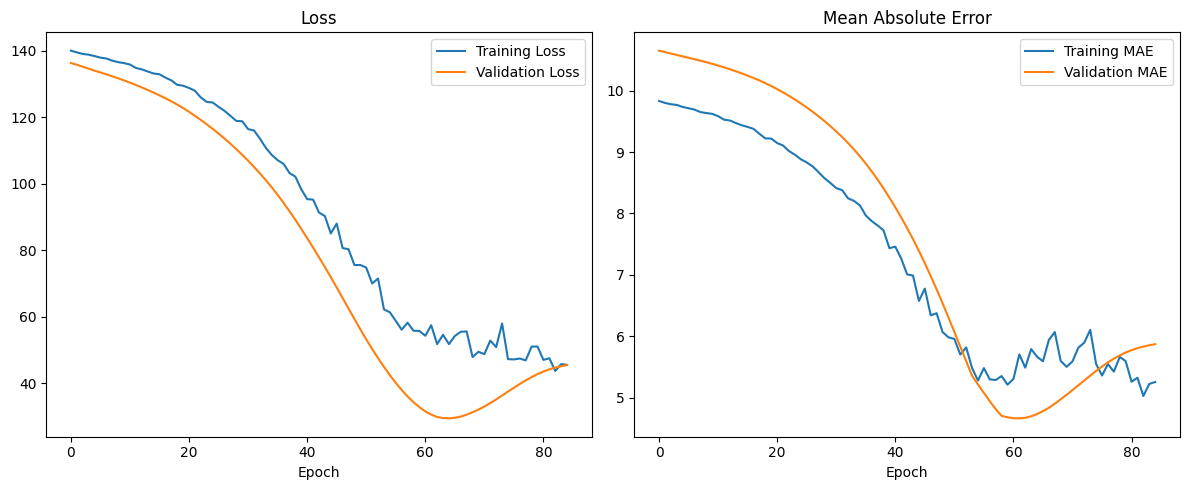

In [151]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig("plots/cnn_training_history.png")
plt.show()

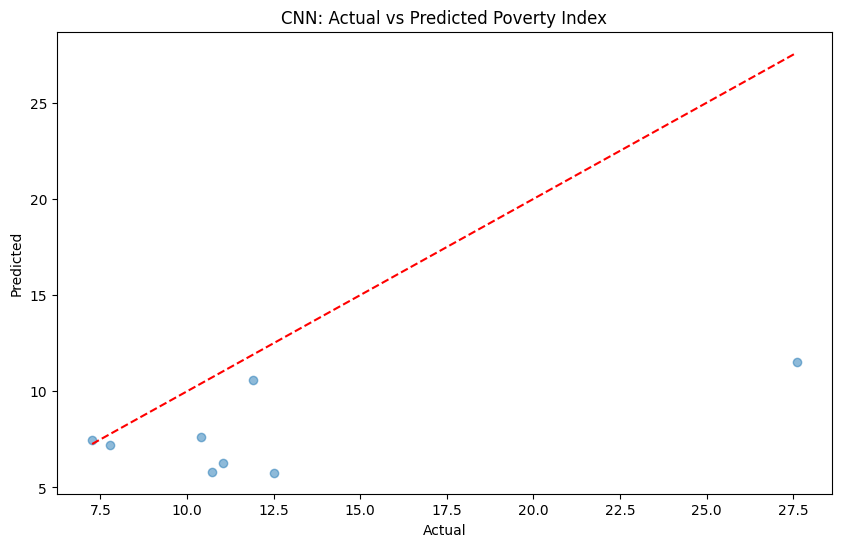

In [152]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, cnn_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('CNN: Actual vs Predicted Poverty Index')
plt.savefig("plots/cnn_predictions.png")
plt.show()

#7. MODEL COMPARISON AND SELECTION


Model Performance Comparison:
                    MAE      RMSE        R²
Random Forest  4.383476  7.724121 -0.658104
CNN            4.673579  6.717313 -0.254021


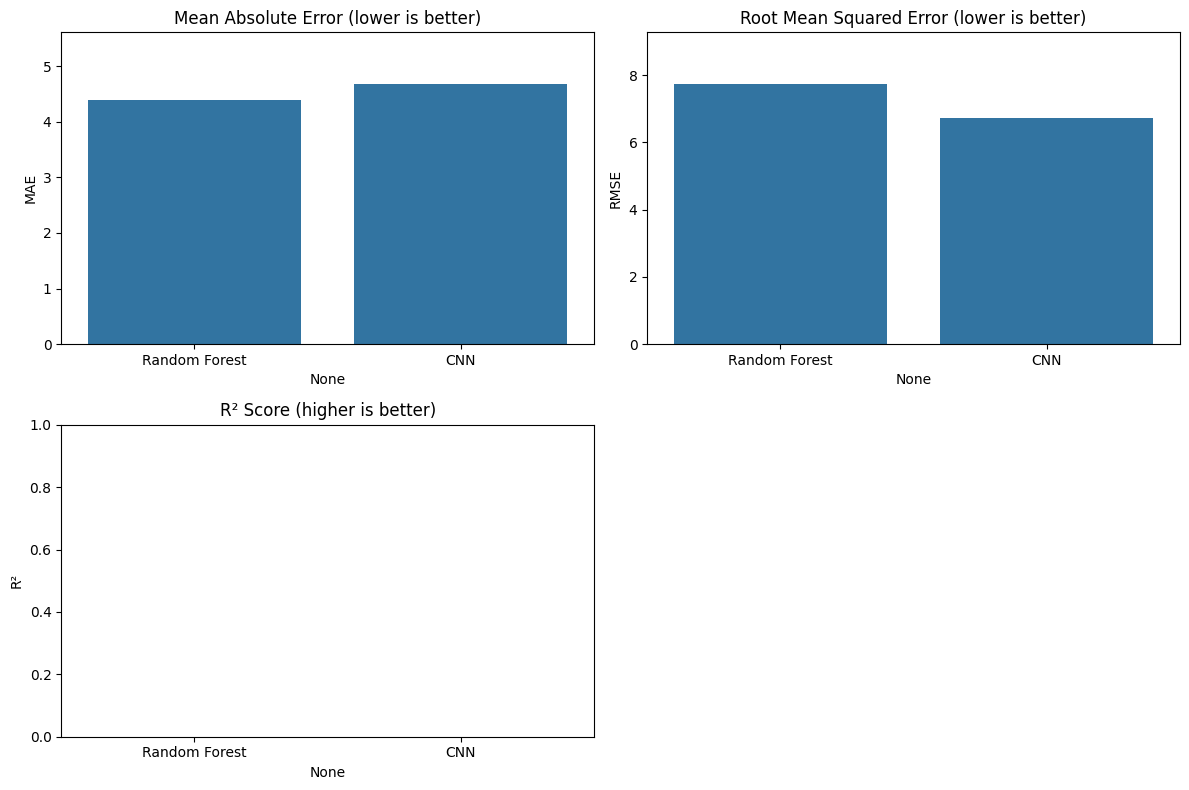


Based on MAE, the best model is: Random Forest


In [153]:
models = ['Random Forest', 'CNN']
metrics = {
    'MAE': [rf_mae, cnn_mae],
    'RMSE': [np.sqrt(rf_mse), np.sqrt(cnn_mse)],
    'R²': [rf_r2, cnn_r2]
}

comparison_df = pd.DataFrame(metrics, index=models)
print("\nModel Performance Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.barplot(x=comparison_df.index, y=comparison_df['MAE'])
plt.title('Mean Absolute Error (lower is better)')
plt.ylim(0, max(comparison_df['MAE']) * 1.2)

plt.subplot(2, 2, 2)
sns.barplot(x=comparison_df.index, y=comparison_df['RMSE'])
plt.title('Root Mean Squared Error (lower is better)')
plt.ylim(0, max(comparison_df['RMSE']) * 1.2)

plt.subplot(2, 2, 3)
sns.barplot(x=comparison_df.index, y=comparison_df['R²'])
plt.title('R² Score (higher is better)')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("plots/model_comparison.png")
plt.show()

best_model = 'Random Forest' if rf_mae < cnn_mae else 'CNN'
print(f"\nBased on MAE, the best model is: {best_model}")

In [154]:
with open("poverty_model.pkl", "wb") as f:
    pickle.dump(rf, f)